# Probe the creativity of LLMs

1. DAT Prompt: Please write 10 nouns that are as irrelevant from each other as possible, in all meanings and uses of the words. Please note that the words you write should have only single word, only nouns (e.g., things, objects, concepts), and no proper nouns (e.g., no specific people or places). Your answer:

1. Baselines:
    * Random
    * Human

1. Models:
    * GPT-4
    * GPT-3.5-turbo
    * Openassistant 30B
    * Vicuna 13B
    * ChatGLM 6B

1. Decoding methods:
    * Greedy search
    * Top-$p$: $p=0.9, t=0.7$

In [1]:
import os
import re
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm, trange
import itertools
import scipy

import nltk
from nltk.corpus import wordnet
from wordfreq import word_frequency

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chenhonghua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Divergent Association Tset (DAT)

In [2]:
# load dat_score function and test

import dat_score

def check_model(model):
    # Compound words are translated into words found in the model
    print(model.validate("cul de sac")) # cul-de-sac

    # Compute the cosine distance between 2 words (0 to 2)
    print(model.distance("cat", "dog")) # 0.1983
    print(model.distance("cat", "thimble")) # 0.8787

    # Compute the DAT score between 2 words (average cosine distance * 100)
    print(model.dat(["cat", "dog"], 2)) # 19.83
    print(model.dat(["cat", "thimble"], 2)) # 87.87

    # Word examples (Figure 1 in paper)
    low = ["arm", "eyes", "feet", "hand", "head", "leg", "body"]
    average = ["bag", "bee", "burger", "feast", "office", "shoes", "tree"]
    high = ["hippo", "jumper", "machinery", "prickle", "tickets", "tomato", "violin"]

    # Compute the DAT score (transformed average cosine distance of first 7 valid words)
    print(model.dat(low)) # 50
    print(model.dat(average)) # 78
    print(model.dat(high)) # 95

In [3]:
# GloVe model from https://nlp.stanford.edu/projects/glove/, use 840B.300d here
model = dat_score.Model("glove.840B.300d.txt", "words.txt")
check_model(model)

cul-de-sac
0.19831448793411255
0.8787002190947533
19.831448793411255
87.87002190947533
50.309727731205165
77.90473784719195
95.2247549447098


In [18]:
# Optional: use word2vec and fasttext model to compare with GloVe
'''
# word2vec model,
model_w2v = dat_score.Model("./GoogleNews-vectors-negative300.bin", "words.txt", 'word2vec')
check_model(model_w2v)
# fasttext model, 
model_ft = dat_score.Model("./wiki-news-300d-1M.vec", "words.txt", 'fasttext')
check_model(model_ft)
'''

None
0.23905426263809204
0.7956064343452454
23.905426263809204
79.56064343452454
73.55577424168587
87.22480151447512
92.65567576512694
cul-de-sac
0.3126683448734314
0.6681814863775846
31.266834487343143
66.81814863775845
51.18007644218656
64.88845784806408
72.24113783222927


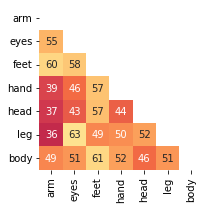

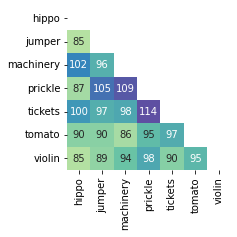

In [4]:
# visualize the DAT
def plot_dat(words, title=None, save_path=None, format="tiff"):
    distance = np.zeros((7, 7))
    for i in range(7):
        for j in range(7):
            distance[i, j] = model.dat([words[i], words[j]], minimum=2)
    mask = np.ones_like(distance, dtype=bool)
    mask[np.tril_indices_from(mask)]=False
    plt.figure(figsize=(3, 3))
    sns.heatmap(distance, mask=mask, vmin=30, vmax=110, cmap="Spectral",
                annot=True, fmt='.0f',
                xticklabels=words[0:7],
                yticklabels=words[0:7],
                square=True, cbar=False
                )
    if title:
        plt.title(f"{title}({np.round(model.dat(words), 1)})")
    if save_path:
        plt.savefig(f"{save_path}.{format}", dpi=300, format=format, bbox_inches='tight')
    plt.show()
    
try:
    low = ["arm", "eyes", "feet", "hand", "head", "leg", "body"]
    high = ["hippo", "jumper", "machinery", "prickle", "tickets", "tomato", "violin"]
    plot_dat(low)
    plot_dat(high)
except:
    print("fail")

## Baseline

In [5]:
def validate(word, wordnet):
    """Clean up word and find best candidate to use"""
    # Strip unwanted characters
    clean = re.sub(r"[^a-zA-Z]+", "", word).strip().lower()
    if len(clean) <= 1:
        return None # Word too short
        # Generate candidates for possible compound words
        # "valid" -> ["valid"]
        # "cul de sac" -> ["cul-de-sac", "culdesac"]
        # "top-hat" -> ["top-hat", "tophat"]
    candidates = []
    if " " in clean:
        candidates.append(re.sub(r" +", "-", clean))
        candidates.append(re.sub(r" +", "", clean))
    else:
        candidates.append(clean)
        if "-" in clean:
            candidates.append(re.sub(r"-+", "", clean))
    for cand in candidates:
        if cand in wordnet:
            return cand # Return first word that is in model
    return None # Could not find valid word

In [6]:
# calculate surprisal
def get_surprisal(words):
    log_frequency = []
    for i in words[0:7]:
        # if (df_nouns_freq['word'] == i).sum() == 1:
            # log_frequency.append(df_nouns_freq[df_nouns_freq['word'] == i]['log_freq'].values)
        if type(i) == str:
            surprisal = -np.log(word_frequency(i, 'en'))
            if surprisal != np.inf:
                log_frequency.append(surprisal)
    # print(len(log_frequency))
    if len(log_frequency) > 6:
        return np.mean(log_frequency)
    else:
        return None

### Random sampling

* Nouns: from [Wordnet](https://wordnet.princeton.edu/)
* Word frequency: from [`wordfreq`](https://libraries.io/pypi/wordfreq)

In [10]:
## load from saved random dataset
df_random = pd.read_json("dataset/random.json")

'''
# sample words using random word frequency

dat_freq = []

for _ in trange(10000):
    frequency_range = np.random.randint(1000, 15000)  # random sample frequency range for model to control surprisal
    nouns_select = df_nouns_freq.iloc[:frequency_range,:]['word'].values
    sample = np.random.permutation(nouns_select.shape[0])
    words = [nouns_select[i] for i in sample[:10]]
    dat_score = model.dat(words)
    dat_freq.append([frequency_range, 
                        words, 
                        sample[:10], 
                        dat_score,
                        df_nouns_freq.iloc[:, :].iloc[sample[:10], :]['log_freq'].mean(),
                        df_nouns_freq.iloc[:, :].iloc[sample[:10], :]['freq'].mean(),
                        np.array(sample[:10]).mean()
                        ])
df_random = pd.DataFrame(dat_freq, columns=['freq_range', 'word', 'freq_rank', 'dat', 'surprisal', 'mean_freq_rate', 'mean_freq_rank'])
'''

# save random dataset
os.makedirs("dataset", exist_ok=True)
df_random.to_json("dataset/random.json")

### Human-level

In [11]:
## load from saved human dataset
df_human = pd.read_json("dataset/human.json")

## load from origin dataset
# use the data of study2 data in Naming unrelated words predicts creativity

'''
df_human = pd.read_csv('human-level/study2.tsv', sep='\t')
df_human['words'] = df_human.apply(lambda x: [i for i in x[-10:]], axis=1)

# calculate surprisal
df_human['surprisal'] = df_human.apply(lambda x: get_surprisal(x['words']), axis=1)
df_human['cat'] = "human"

print("shape of human dataset:", df_human.shape)
# save human dataset
os.makedirs("dataset", exist_ok=True)
df_human.to_json("dataset/human.json")
'''

'\ndf_human = pd.read_csv(\'human-level/study2.tsv\', sep=\'\t\')\ndf_human[\'words\'] = df_human.apply(lambda x: [i for i in x[-10:]], axis=1)\n\n# calculate surprisal\ndf_human[\'surprisal\'] = df_human.apply(lambda x: get_surprisal(x[\'words\']), axis=1)\ndf_human[\'cat\'] = "human"\n\nprint("shape of human dataset:", df_human.shape)\n# save human dataset\nos.makedirs("dataset", exist_ok=True)\ndf_human.to_json("dataset/human.json")\n'

The results using the number of words over seven are stable.

The results using the number of words over seven are stable.

#### Plot

100%|██████████| 8572/8572 [00:07<00:00, 1091.59it/s]


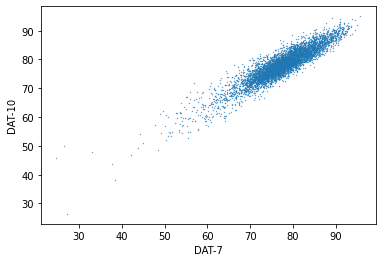

In [12]:
# compare different num_words (parameter: minimum) used to calculate DAT

num_words = 10
words = df_human['words'].values
dat2_all = []

for word in tqdm(words):
    try:
        dat2 = model.dat(word, minimum=num_words)
        dat2_all.append(dat2)
    except:
        # print(word)
        dat2_all.append(None)
plt.scatter(df_human['dat'], dat2_all, s=0.1)
plt.ylabel(f"DAT-{num_words}")
plt.xlabel("DAT-7")
plt.show()

(70.0, 85.0)

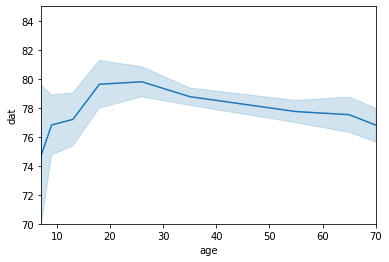

In [13]:
df_human['age'] = df_human['age'].astype('int')
sns.lineplot(data=df_human, x='age', y='dat', errorbar=("se", 5))
plt.xlim(7,70)
plt.ylim(70, 85)
# plt.ylim(74, 82)

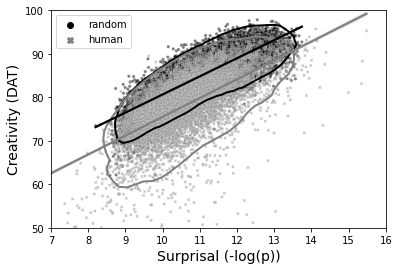

In [14]:
# Figure 8: two baselines

c1 = 'black'
c2 = 'grey'

df_human['cat'] = 'human'
df_random['cat'] = 'random'
df_baseline = pd.concat(
    [df_random[['surprisal', 'dat', 'cat']], df_human[['surprisal', 'dat', 'cat']]], axis=0
    )

fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.scatterplot(
    data=df_baseline, x='surprisal', y='dat', s=10, alpha=0.5, hue='cat', style='cat', palette={"human": c2, "random": c1}
    )
handles, labels = axes.get_legend_handles_labels()

# random baseline 
sns.regplot(
    data=df_random, x='surprisal', y='dat', scatter=False, label='random', 
    line_kws={"color":c1}, order=1
    )

sns.kdeplot(
    data=df_random, x='surprisal', y='dat', levels=2, color=c1, linewidths=2, gridsize=50
    )

# human baseline
sns.regplot(
    data=df_human, x='surprisal', y='dat', scatter=False, label='human', 
    line_kws={"color":c2}, order=1
    )

sns.kdeplot(
    data=df_human, x='surprisal', y='dat', levels=2, color=c2, linewidths=2, gridsize=50
    )


plt.xlabel("Surprisal (-log(p))", fontsize=14)
plt.ylabel("Creativity (DAT)", fontsize=14)
plt.ylim(50, 100)
plt.xlim(7, 16)
plt.legend(fontsize=12)
plt.legend(handles=handles, labels=labels)
# plt.savefig("figure/human-level.png", dpi=300)

## Experiment

In [15]:
# filter the answer with repetitive or non-nominal words
def noun_filter(df):
    filter = []   
    # print(df['words'])
    for i in df['words']:
        f = True
        if len(list(set(i))) < 10:  # examine the repetition
            f = False
            filter.append(f)
            continue
        for j in i[0:7]:
            try:
                if len(wordnet.synsets(j, pos=wordnet.NOUN)) == 0:  # examine the nominal
                    f = False
                    break
            except:
                print(i, j)
        filter.append(f)
    return filter

In [16]:
def generate_df_model(path):
    fns = glob.glob(path)
    data_list = []
    for fn in tqdm(fns):
        df_model = pd.read_json(fn, lines=True)
        df_model['cat'] = fn.split('/')[-1].replace('.json', '')
        data_list.append(df_model)
    df_model = pd.concat(data_list)
    df_model = df_model.dropna()
    df_model['dat'] = df_model.apply(lambda x: model.dat(x['words']), axis=1)
    df_model['surprisal'] = df_model.apply(lambda x: get_surprisal(x['words']), axis=1)
    df_model['t'] = df_model['t'].apply(lambda x: np.round(x, 2))
    df_model = df_model.dropna()
    df_model.index = range(df_model.shape[0])
    return df_model

In [7]:
def add_dat(model, df, name):
    words = df['words'].values
    dat = []
    for word in tqdm(words):
        try:
            dat.append(model.dat(word))
        except:
            dat.append(None)
    df[name] = dat
    return df

In [17]:
# define ticks
model_ticks = ['gpt-4', 'gpt-3.5-turbo', 'oa-30b', 'vicuna-13b', 'chatglm-6b']
hue_order = model_ticks.copy()
hue_order.append('human')

### Top-p sampling

In [18]:
## load from saved integration dataset
df_integration = pd.read_json("dataset/integration.json", lines=True)

In [19]:
## load from origin dataset
# get data from each model in "Top_p/"

llm_fn = glob.glob("Top_p/*/*.txt")
llm_fn.sort()

df_top_p = {}
for i, fn in enumerate(tqdm(llm_fn)):
    with open(fn, 'r') as f:
        text = f.read()
        f.close()
    model_id = fn.split('/')[1]
    data = [i.split('\n') for i in text.split('\n\n')]
    df_model = pd.DataFrame(data, columns=
            ['temperature', 'word.1', 'word.2', 'word.3', 'word.4', 'word.5', 'word.6', 'word.7', 'word.8', 'word.9', 'word.10'])
    df_model['words'] = df_model.apply(lambda x: [i for i in x[-10:]], axis=1)
    df_model = df_model.iloc[noun_filter(df_model), :]
    df_model['surprisal'] = df_model.apply(lambda x: get_surprisal(x['words']), axis=1)
    df_model['dat'] = df_model['words'].apply(lambda x: model.dat(x, minimum=7))
    df_model['cat'] = model_id
    df_top_p[model_id] = df_model
    # break

data_list=[df_top_p[i] for i in df_top_p.keys()]
data_list.extend([df_human])
df_integration = pd.concat([i.filter(['cat', 'dat', 'surprisal', 'words']) for i in data_list], ignore_index=True,)
df_integration = df_integration.dropna()


# df_integration.to_json('dataset/integration.json', orient='records', lines=True) # save the dataset into './dataset/'
df_integration['cat'].value_counts()

100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


human            8006
oa-30b            454
chatglm-6b        341
vicuna-13b        202
gpt-3.5-turbo      79
gpt-4              40
Name: cat, dtype: int64

In [ ]:
# Optional: compare the GloVe with other word embeddings, the results are similar
'''
df_integration = add_dat(model_w2v, df_integration, 'dat_w2v')
df_integration = add_dat(model_ft, df_integration, 'dat_ft')
df_integration[df_integration['cat']!='human'][['dat', 'dat_w2v', 'dat_ft']].corr()
'''

2.505608202976812
3.5584394824605257
9.411309206509928
6.041017725690591
6.046580565857202


(50.0, 105.0)

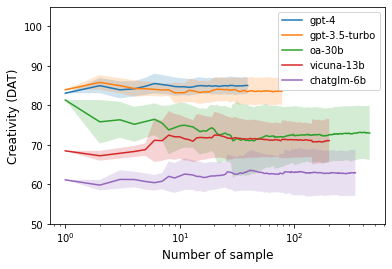

In [21]:
# Fig 7: convergence analysis
def plot_sample_convergence(df_model, var="dat"):
    dat_sample = []
    for i in range(1, df_model.shape[0]):
        dat_sample.append(df_model[var][:i].dropna().values)
    mean = np.array([i.mean() for i in dat_sample])
    std =  np.array([i.std() for i in dat_sample])
    x = range(1, df_model.shape[0])
    plt.plot(x, mean)
    plt.fill_between(x, mean-std, mean+std, alpha=0.2)
    print(std.max())

for model_id in model_ticks:
    plot_sample_convergence(df_top_p[model_id], 'dat')
plt.ylim(50, 100)
plt.xscale('log')
plt.legend(model_ticks)
plt.xlabel("Number of sample", fontsize=12)
plt.ylabel("Creativity (DAT)", fontsize=12)
plt.ylim(50, 105)
# plt.savefig('figure/convergence.png', dpi=300)

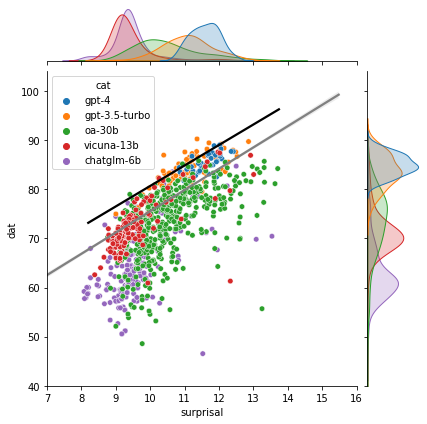

In [22]:
# scatter plot
sns.jointplot(data=df_integration[df_integration['cat'] != 'human'], x='surprisal', y='dat', 
              hue='cat', hue_order=model_ticks,
              kind='scatter',
              joint_kws={"s":30},
              marginal_kws={"common_norm":False, "fill":True}, legend=True)
sns.regplot(data=df_random, x='surprisal', y='dat', 
            scatter=False, 
            line_kws={"color":"black"})
sns.regplot(data=df_human, x='surprisal', y='dat', 
            scatter=False, label='human', 
            line_kws={"color":"grey"}, scatter_kws={"color":"grey", "s":1, "alpha":0.1})
plt.ylim(40, )
plt.xlim(7, 16)
plt.show()

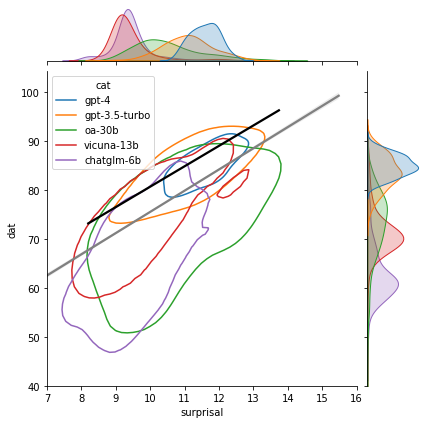

In [22]:
# kde plot
sns.jointplot(data=df_integration[df_integration['cat'] != 'human'], x='surprisal', y='dat', 
              hue='cat', hue_order=model_ticks,
              kind='kde', 
              joint_kws={"levels":1, "gridsize":50, "common_norm":False, "bw_adjust":1.5, "thresh":0.05}, 
              marginal_kws={"common_norm":False, "fill":True}, legend=True)
sns.regplot(data=df_random, x='surprisal', y='dat', scatter=False, 
            line_kws={"color":"black"})
sns.regplot(data=df_human, x='surprisal', y='dat', scatter=False, label='human', 
            line_kws={"color":"grey"}, scatter_kws={"color":"grey", "s":1, "alpha":0.1})
plt.ylim(40, )
plt.xlim(7, 16)
plt.show()

### Greedy search

In [23]:
# get data from each model
llm_fn = glob.glob("greedy_search/*")
llm_fn = llm_fn[0]

with open(llm_fn, 'r') as f:
    text = f.read()
    f.close()
data = [i.split('\n') for i in text.split('\n\n')]
df_greedy = pd.DataFrame(data, columns=
            ['cat', 'word.1', 'word.2', 'word.3', 'word.4', 'word.5', 'word.6', 'word.7', 'word.8', 'word.9', 'word.10'])
df_greedy['words'] = df_greedy.apply(lambda x: [i for i in x[-10:]], axis=1)
df_greedy = df_greedy.iloc[noun_filter(df_greedy), :]
df_greedy['surprisal'] = df_greedy.apply(lambda x: get_surprisal(x['words']), axis=1)
df_greedy['dat'] = df_greedy['words'].apply(lambda x: model.dat(x, minimum=7))
df_greedy[['cat', 'surprisal', 'dat']]

,cat,surprisal,dat
0,gpt-4,12.539404,89.059226
1,gpt-3.5-turbo,10.388747,80.778920
2,oa-30b,9.690945,64.905032
3,vicuna-13b,9.262866,69.128985
4,chatglm-6b,9.364950,61.166665
5,BloomChat-176b,11.895369,78.970219
6,text-davinci-003,9.677871,74.757218
7,dolly-v2-12b,9.443208,70.952764
8,koala-13b,10.984190,72.225940
9,alpaca-13b,9.447296,70.391187


### Plot

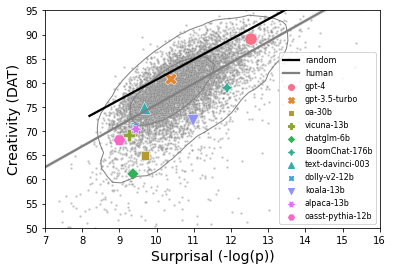

In [24]:
# Fig5: greedy search for more models
plt.figure(figsize=(6, 4))
sns.regplot(data=df_random, x='surprisal', y='dat', scatter=False, label='random', line_kws={"color":"black"})
sns.scatterplot(data=df_human, x='surprisal', y='dat', s=5, alpha=0.5, c="grey", legend=False)
sns.regplot(data=df_human, x='surprisal', y='dat', scatter=False, label='human', line_kws={"color":"grey"})

sns.scatterplot(df_greedy, x='surprisal', y='dat', hue='cat', s=150, edgecolor='w', linewidth=0.5, 
                style='cat')
sns.kdeplot(data=df_human, x='surprisal', y='dat', levels=3, color="grey", linewidths=1, gridsize=50)

plt.ylim(50, 95)
plt.xlim(7, 16)
plt.xlabel("Surprisal (-log(p))", fontsize=14)
plt.ylabel("Creativity (DAT)", fontsize=14)
plt.legend(fontsize=8)
# plt.savefig("figure/model_greedy_7.png", dpi=300)
# plt.savefig("figure/model_greedy_7.svg", dpi=300)

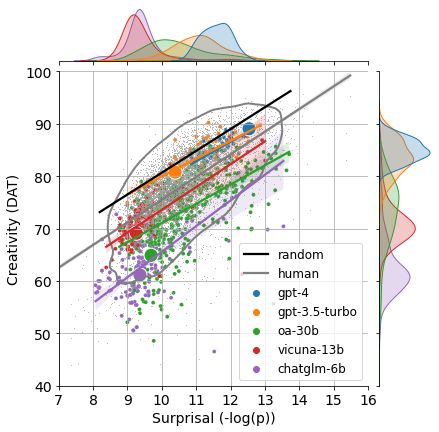

In [25]:
# Fig3: greedy search + top-p

sns.jointplot(data=df_integration[df_integration['cat'] != 'human'], x='surprisal', y='dat', hue='cat', hue_order=model_ticks,
              kind='scatter',
              # joint_kws={"levels":1, "gridsize":50, "common_norm":False, "bw_adjust":1.2, "thresh":0.05}, 
              joint_kws={"s":15, "linewidth":0.1},
              marginal_kws={"common_norm":False, "fill":True}, legend=True)

for model_id in model_ticks:
    sns.regplot(data=df_top_p[model_id], x='surprisal', y='dat', scatter=False)
sns.kdeplot(data=df_human, x='surprisal', y='dat', levels=2, color="grey", linewidths=2, gridsize=100)
sns.scatterplot(data=df_human, x='surprisal', y='dat', s=1, alpha=0.8, c="grey", legend=False)
sns.regplot(data=df_random, x='surprisal', y='dat', scatter=False, label="random",
            line_kws={"color":"black"})
sns.regplot(data=df_human, x='surprisal', y='dat', scatter=False, label='human', 
            line_kws={"color":"grey"}, scatter_kws={"color":"grey", "s":1, "alpha":0.1})

sns.scatterplot(df_greedy.iloc[:5, :], x='surprisal', y='dat',hue='cat', 
                # hue_order=['chatglm-6b', 'chatgpt', 'gpt-4', 'oa_30b', 'vicuna-13b'], 
                s=200, edgecolor='w', linewidth=1, legend=False)

plt.xlabel("Surprisal (-log(p))", fontsize=14)
plt.ylabel("Creativity (DAT)", fontsize=14)
plt.ylim(40, 100)
plt.xlim(7, 16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

# plt.savefig("figure/model_greedy+sample.png", dpi=300, bbox_inches='tight')
# plt.savefig("figure/model_greedy+sample.svg", dpi=300, bbox_inches='tight')
plt.show()

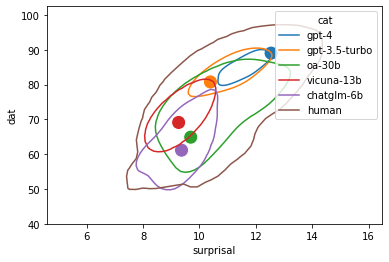

In [26]:
# kde plot
sns.kdeplot(data=df_integration, x='surprisal', y='dat', hue_order=hue_order, common_norm=True,
            bw_adjust=1.5, gridsize=50,
            hue='cat', levels=2, thresh=0.05)
sns.scatterplot(df_greedy.iloc[:5, :], x='surprisal', y='dat',hue='cat', 
                # hue_order=['chatglm-6b', 'chatgpt', 'gpt-4', 'oa_30b', 'vicuna-13b'], 
                s=200, edgecolor='w', linewidth=1, legend=False)
plt.ylim(40, )
plt.show()

gpt-4 ['Giraffe', 'Microscope', 'Volcano', 'Tambourine', 'Philosophy', 'Refrigerator', 'Asteroid', 'Calligraphy', 'Marshmallow', 'Shoelace']


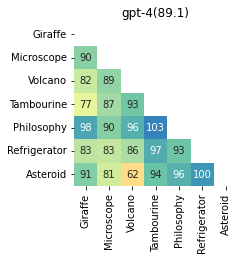

In [28]:
## Fig2a: Plot DAT
for i in df_greedy.index[:5]:
    data = df_greedy.loc[i]
    print(data['cat'], data['words'])
    plot_dat(data['words'], title=data['cat'], save_path=f"figure/dat_{data['cat']}", format="png")
    break

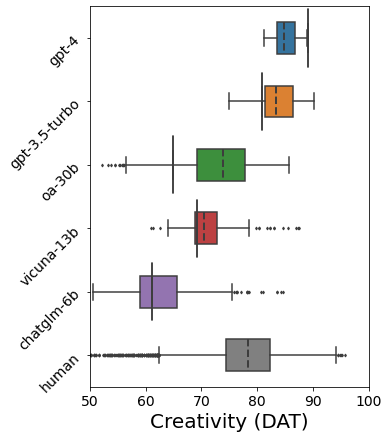

In [29]:
# Fig2b: boxplot
plt.figure(figsize=(5, 7))
sns.boxplot(data=df_greedy.iloc[:5, :], y='cat', x='dat', width=0.9)
sns.boxplot(data=df_integration, 
            y='cat', x='dat',
            order=hue_order,
            palette=['C0', 'C1', 'C2', 'C3', 'C4', 'grey'],
            width=0.5, saturation=0.7, 
            fliersize=2,
            medianprops = {'linestyle':'--', 'linewidth':2,},
            )
plt.yticks(rotation=45, fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel(None)
plt.xlabel("Creativity (DAT)", fontsize=20)
plt.xlim(50, 100)
# plt.savefig("figure/dat_model_box.svg", format="svg")
# plt.savefig("figure/dat_model_box.png")
plt.show()

In [30]:
# get percentile

def get_percentile(percentile, x):
    for index, percent in percentile:
        if percent > x:
            return index - 0.1
    return index

percentile = []
for i in np.linspace(0, 100, 1001):
    percentile.append([i,np.percentile(df_human['dat'].values, i)])
percentile = np.array(percentile)
df_greedy['percentile'] = df_greedy['dat'].apply(lambda x: get_percentile(percentile, x))

df_median = df_integration.groupby('cat', as_index=False).median()
df_median['percentile'] = df_median['dat'].apply(lambda x: get_percentile(percentile, x))

df_median = df_median[df_median['cat']!='human']
df_median = df_median.reindex(index=[2, 1, 4, 5, 0])

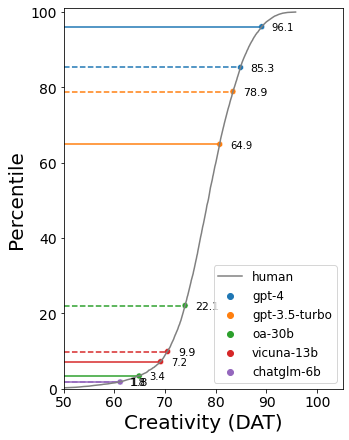

In [31]:
# Fig2c: percentile plot
plt.figure(figsize=(5, 7))
sns.scatterplot(data=df_greedy.iloc[:5, :], x='dat', y='percentile', hue='cat', legend=True)
for i, p in enumerate(df_greedy.iloc[:5, :][['dat', 'percentile']].values):
    plt.hlines(p[1], xmin=50, xmax=p[0], colors=f'C{i}')
    plt.text(x=p[0]+2, y=p[1]-1, s='{}'.format(np.around(p[1], 3)))
    # print(p[1])

sns.scatterplot(data=df_median, x='dat', y='percentile', hue='cat', legend=False)
for i, p in enumerate(df_median[['dat', 'percentile']].values):
    plt.hlines(p[1], xmin=50, xmax=p[0], colors=f'C{i}', linestyles='--')
    plt.text(x=p[0]+2, y=p[1]-1, s='{}'.format(np.around(p[1], 3)), fontsize=11)


line = plt.plot(percentile[:, 1], percentile[:, 0], c='grey', label="human")
plt.xlim(50, 105)
plt.ylim(0, 101)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Creativity (DAT)", fontsize=20)
plt.ylabel("Percentile", fontsize=20)
plt.legend(loc='lower right', fontsize=12)
# plt.savefig("figure/percentile.svg", format="svg")
plt.savefig("figure/percentile.png")
plt.show()

Controlling surprisal

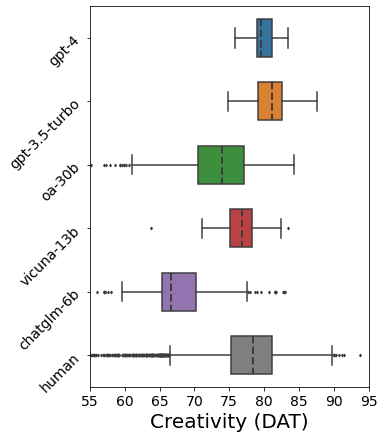

In [33]:
# Fig10: controlling surprisal
def regress_out(a, b):
    """Regress b from a keeping a's original mean."""
    a_mean = a.mean()
    a = a - a_mean
    b = b - b.mean()
    b = np.c_[b]
    a_prime = a - b.dot(np.linalg.pinv(b).dot(a))
    return np.asarray(a_prime + a_mean).reshape(a.shape)

df_integration['dat_partial'] = regress_out(df_integration['dat'], df_integration['surprisal'])
plt.figure(figsize=(5, 7))
sns.boxplot(data=df_integration, y='cat', x='dat_partial',
               order=hue_order,
               palette=['C0', 'C1', 'C2', 'C3', 'C4', 'grey'],
               width=0.6, 
               saturation=0.7, 
               fliersize=2,
               medianprops = {'linestyle':'--', 'linewidth':2,},
               )
plt.yticks(rotation=45, fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel(None)
plt.xlabel("Creativity (DAT)", fontsize=20)
plt.xlim(55, 95)
# plt.savefig("figure/dat_model_box_partial.svg", format="svg", bbox_inches='tight')
# plt.savefig("figure/dat_model_box_partial.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

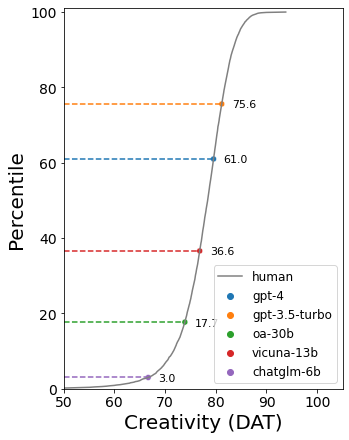

In [34]:
percentile = []
for i in np.linspace(0, 100, 1001):
    percentile.append([i, np.percentile(df_integration[df_integration['cat'] == 'human']['dat_partial'].values, i)])
percentile = np.array(percentile)

df_median_partial = df_integration.groupby('cat', as_index=False).median()
df_median_partial['percentile'] = df_median_partial['dat_partial'].apply(lambda x: get_percentile(percentile, x))

df_median_partial = df_median_partial[df_median_partial['cat']!='human']
df_median_partial = df_median_partial.reindex(index=[2, 1, 4, 5, 0])

plt.figure(figsize=(5, 7))
sns.scatterplot(data=df_median_partial, x='dat_partial', y='percentile', hue='cat')
for i, p in enumerate(df_median_partial[['dat_partial', 'percentile']].values):
    plt.hlines(p[1], xmin=50, xmax=p[0], colors=f'C{i}', linestyles='--')
    plt.text(x=p[0]+2, y=p[1]-1, s='{}'.format(np.around(p[1], 3)), fontsize=11)
line = plt.plot(percentile[:, 1], percentile[:, 0], c='grey', label="human")
plt.xlim(50, 105)
plt.ylim(0, 101)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Creativity (DAT)", fontsize=20)
plt.ylabel("Percentile", fontsize=20)
plt.legend(loc='lower right', fontsize=12)
# plt.savefig("figure/percentile_partial.svg", format="svg", bbox_inches='tight')
# plt.savefig("figure/percentile_partial.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

### the Effect of temperatue

In [35]:
def validate(word):
    """Clean up word and find best candidate to use"""
    # Strip unwanted characters
    clean = re.sub(r"[^a-zA-Z ]+", "", word).strip().lower()
    if len(clean) <= 1:
        return None # Word too short
    if " " in clean:
        clean = clean.split(" ")
        for i in clean:
            if i != "a":
                return i
    else:
        return clean

def clean(ans):
  # ans = ans[:100]
  if "\n" in ans and len(ans.split("\n")) >= 10:
    words = ans.split("\n")
  elif "," in ans:
    words = ans.split(',')
    # print(",split:", words, '\n\n')
  elif "*" in ans:
     words = ans.split('*')
  else:
     return None
  words = [validate(word) for word in words]
  if len(words)>10:
    words = words[:10]
  if None not in words and len(list(set(words))) == 10:
    return words
  else:
    return None

In [38]:
df_t = generate_df_model('temperature/*.json')

100%|██████████| 5/5 [00:00<00:00, 148.16it/s]
/var/folders/4h/rkjx20rn0rj88wn3wpgq56xm0000gn/T/ipykernel_12233/1336459145.py:8: RuntimeWarning: divide by zero encountered in log
  surprisal = -np.log(word_frequency(i, 'en'))


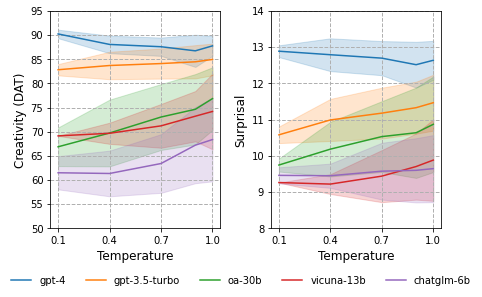

In [37]:
# Fig5: plot surprisal and dat in two subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
fig.subplots_adjust(wspace=0.3)
sns.lineplot(data=df_t, x='t', y='dat', hue='cat', ax=axes[0], hue_order=model_ticks, legend=False, errorbar='sd')
sns.lineplot(data=df_t, x='t', y='surprisal', hue='cat', ax=axes[1], hue_order=model_ticks, errorbar='sd')
axes[0].grid(linestyle='--', linewidth=1)
axes[1].grid(linestyle='--', linewidth=1)
axes[0].set_xticks(np.arange(0.1, 1.1, 0.3))
axes[1].set_xticks(np.arange(0.1, 1.1, 0.3))
axes[0].set_ylim(50, 95)
axes[1].set_ylim(8, 14)
axes[0].set_ylabel("Creativity (DAT)", fontsize=12)
axes[1].set_ylabel("Surprisal", fontsize=12)
axes[1].set_xlabel("Temperature", fontsize=12)
axes[0].set_xlabel("Temperature", fontsize=12)

# change the title of legend
handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(bbox_to_anchor=(1.2, -0.2), borderaxespad=0, ncol=5, fontsize=10, frameon=False)
plt.savefig('figure/temp.png', dpi=300, bbox_inches='tight')
plt.show()

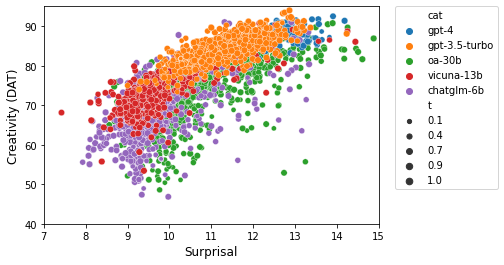

In [39]:
sns.scatterplot(data=df_t, x='surprisal', y='dat', hue='cat', size='t', size_norm=(0.1, 2), hue_order=model_ticks)
plt.xlim(7, 15)
plt.ylim(40, 95)
plt.xlabel("Surprisal", fontsize=12)
plt.ylabel("Creativity (DAT)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

(50.0, 95.0)

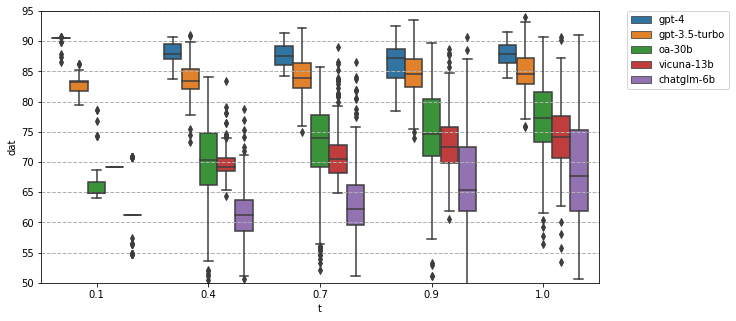

In [40]:
plt.figure(figsize=(10, 5))
plt.yticks(np.arange(50, 100, 5))
plt.grid(linestyle='--', linewidth=1)
sns.boxplot(data=df_t, x='t', y='dat', hue='cat', hue_order=model_ticks)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(50, 95)

#### the Effect of temperature across p

In [41]:
fn = 'temperature/gpt-3.5-turbo.json'
df_t_p = pd.read_json(fn, lines=True)
df_t_p.head()

,t,p,ans,words
0,0.1,0.5,1. Chair\n2. Cloud\n3. Freedom\n4. Guitar\n5. ...,"[chair, cloud, freedom, guitar, mathematics, o..."
1,0.1,0.5,1. Chair\n2. Cloud\n3. Freedom\n4. Guitar\n5. ...,"[chair, cloud, freedom, guitar, mathematics, p..."
2,0.1,0.5,1. Chair\n2. Cloud\n3. Freedom\n4. Guitar\n5. ...,"[chair, cloud, freedom, guitar, mathematics, p..."
3,0.1,0.5,1. Chair\n2. Cloud\n3. Freedom\n4. Guitar\n5. ...,"[chair, cloud, freedom, guitar, mathematics, p..."
4,0.1,0.5,1. Chair\n2. Cloud\n3. Freedom\n4. Guitar\n5. ...,"[chair, cloud, freedom, guitar, mathematics, p..."


In [42]:
df_t_p = df_t_p.dropna()
dat_ans = [model.dat(df_t_p['words'][i]) for i in range(len(df_t_p))]
df_t_p['dat'] = dat_ans
df_t_p['surprisal'] = df_t_p.apply(lambda x: get_surprisal(x['words']), axis=1)
df_t_p['t'] = df_t_p['t'].apply(lambda x: np.round(x, 2))
df_t_p['p'] = df_t_p['p'].apply(lambda x: np.round(x, 2))
df_t_p.shape

(1000, 6)

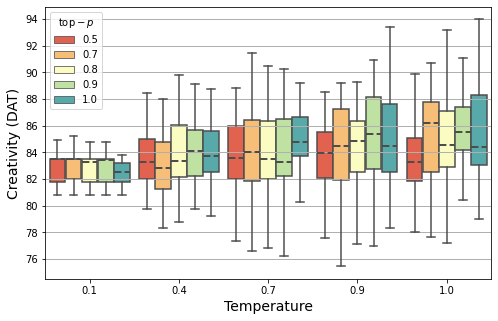

In [43]:
plt.figure(figsize=(8, 5))
plt.yticks(np.arange(70, 100, 2))
plt.grid(linestyle='-', linewidth=1)
sns.boxplot(data=df_t_p, x='t', y='dat', hue='p', palette='Spectral', width=0.9, showfliers=False, 
           saturation=0.9, medianprops = {'linestyle':'--', 'linewidth':2,}
              )
plt.legend(title=r'$\mathrm{top-}\mathit{p}$', fontsize=10)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Creativity (DAT)", fontsize=14)
# plt.savefig("figure/dat_temp.svg", format="svg")
# plt.savefig("figure/dat_temp.png", format="svg", dpi=300)
plt.show()

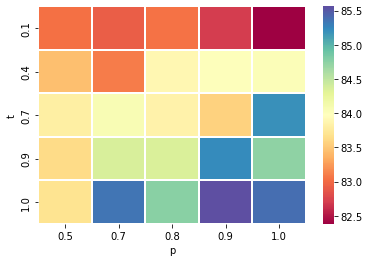

In [46]:
# plot combination of temperature and p in heatmap
df_t_p_mean = df_t_p.groupby(['t', 'p'], as_index=False).mean()
df_t_p_std = df_t_p.groupby(['t', 'p'], as_index=False).std()
mean_matrix = df_t_p_mean.pivot(index='t', columns='p', values='dat')
std_matrix = df_t_p_std.pivot(index='t', columns='p', values='dat')
sns.heatmap(mean_matrix, cmap="Spectral", linewidth=0.2)
plt.show()

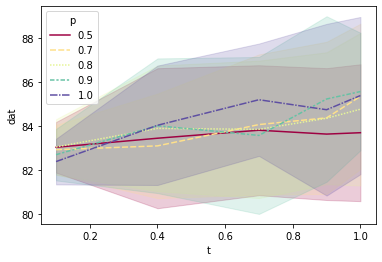

In [47]:
sns.lineplot(data=df_t_p, x='t', y='dat', hue='p', style='p', palette='Spectral', errorbar='sd')
plt.show()

### Validating DAT

In [48]:
df_validate = generate_df_model('validating_DAT/*.json')
for cat in df_validate['cat'].unique():
    df_model = df_integration[df_integration['cat']==cat]
    df_model['condition']='DAT'
    df_model['t']=0.7
    df_model['p']=0.9
    df_model['ans']=''
    df_validate = pd.concat([df_validate, df_model], axis=0)

100%|██████████| 5/5 [00:00<00:00, 197.86it/s]
/var/folders/4h/rkjx20rn0rj88wn3wpgq56xm0000gn/T/ipykernel_12233/1336459145.py:8: RuntimeWarning: divide by zero encountered in log
  surprisal = -np.log(word_frequency(i, 'en'))
/Users/chenhonghua/opt/anaconda3/envs/heiheihei/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='surprisal', ylabel='dat'>

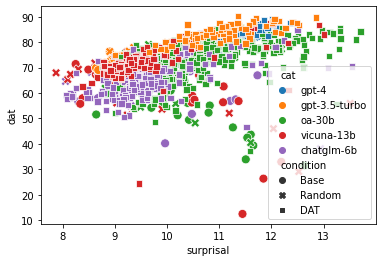

In [49]:
sns.scatterplot(
        data=df_validate, x='surprisal', y='dat', hue='cat', hue_order=model_ticks, style='condition',
        alpha=1, edgecolor='w', s=80,
        )

(array([0, 1, 2]),
 [Text(0, 0, 'Base'), Text(1, 0, 'Random'), Text(2, 0, 'DAT')])

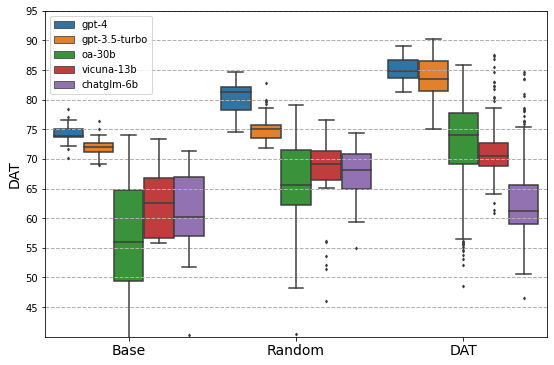

In [50]:
plt.figure(figsize=(9, 6))
plt.yticks(np.arange(45, 100, 5))
plt.grid(linestyle='--', linewidth=1)
sns.boxplot(
    data=df_validate, x='condition', y='dat', 
    hue='cat', 
    hue_order=model_ticks,
    width=0.9,
    dodge=True,
    fliersize=2,
)

plt.legend()#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(40, 95)
plt.ylabel('DAT', fontsize=14)
plt.xlabel('')
plt.xticks(fontsize=14)
# plt.savefig("figure/validating.png", dpi=300)
# plt.savefig("figure/validating.svg")


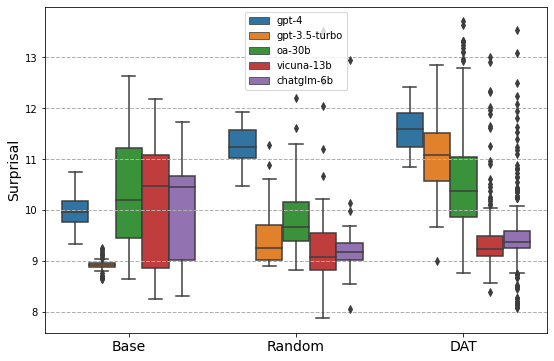

In [52]:
plt.figure(figsize=(9, 6))
plt.grid(linestyle='--', linewidth=1)
sns.boxplot(data=df_validate, x='condition', y='surprisal', hue='cat', hue_order=model_ticks)
plt.legend()#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Surprisal', fontsize=14)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.show()